In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from infeas import analyse
import easyvvuq as uq

In [2]:
campaign, samples = analyse.read_campaign(campaign_name="example_local")
samples

Reading in campaign database.
Campaign read in. Number of samples = 250


,run_id,iteration,step_ucsc_8,step_ref_69,step_ucblbe,fdene,hfact,coreradius,fimp_2,fimp_14,...,alstroh,sig_tf_wp_max,aspect,boundu_2,triang,vary_param,startupratio,step_ucsc_0,step_cconshtf,cdirt
0,1,0,2154.126473,18.463189,11593.509701,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,18210.0
1,2,0,3183.793831,18.463189,11593.509701,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,18746.0
2,3,0,2154.126473,13.008458,11593.509701,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,16787.0
3,4,0,2154.126473,18.463189,5104.292797,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,17537.0
4,5,0,3183.793831,13.008458,5104.292797,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,16648.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245,246,0,1286.774644,14.203136,4938.203688,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,15957.0
246,247,0,3664.453272,14.203136,4938.203688,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,17193.0
247,248,0,1286.774644,18.993587,4938.203688,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,17207.0
248,249,0,1286.774644,14.203136,10483.022919,1.2,1.2,0.75,0.1,0.00001,...,660000000.0,640000000.0,3.1,12.0,0.5,,1.0,1230.0,91.0,16532.0


## Analysis

Check out the QOIs from the samples.

In [3]:
qois = [
    "cdirt",
]
samples[qois].describe()

,cdirt
count,250.000000
mean,17557.904000
std,1502.651512
min,14265.000000
25%,16326.500000
50%,17523.000000
75%,18752.500000
max,21026.000000


### Most violated constraints

Find the most violated constraints (by mean).

Plotting violated constraint means.


Text(0, 0.5, 'Constraint')

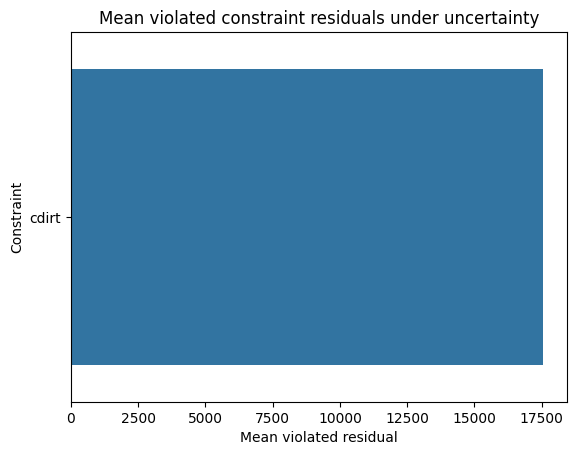

In [4]:
print("Plotting violated constraint means.")
# Get absolute values of violated constraint residuals
# Abs values before mean: be fair to eq constraints (either side of 0)
vio_means_series = samples[qois].abs().mean().sort_values(ascending=False)
vio_means = pd.DataFrame(vio_means_series, columns=["mean"])
vio_means["variable"] = vio_means.index
vio_means.reset_index(drop=True)

# Exclude objf and vio-constr_res
filter_qois = ["norm_objf", "rms_vio_constr_res"]
constrs_mask = ~vio_means["variable"].isin(filter_qois)
vio_means_filt = vio_means[constrs_mask]

# Plot
fig, ax = plt.subplots()
sns.barplot(data=vio_means_filt, x="mean", y="variable", ax=ax)
ax.set_title("Mean violated constraint residuals under uncertainty")
ax.set_xlabel("Mean violated residual")
ax.set_ylabel("Constraint")
# fig.savefig("mean_vio_constr_res.png")

### Probability Distribution

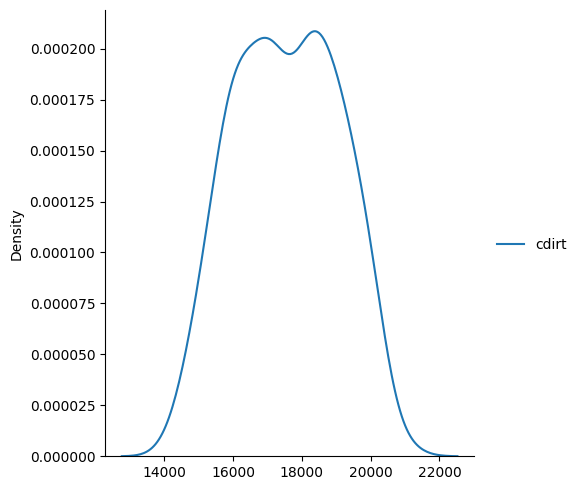

In [5]:
# fig, ax = plt.subplots()

study_cdf_dfs = []

results = campaign.analyse(
    qoi_cols=["cdirt"]
)
# get_distribution() method not implemented for MCSampler
# not implemented in AnalysisResults (base) or QMCAnalysisResults (returned in MC case)
# Have to get distribution another way

# if type(results) == uq.analysis.qmc_analysis.QMCAnalysisResults:
# else:
#     dist = results.get_distribution(qoi="rms_vio_constr_res")

#     # Locations for density function to be evaluated
#     x = np.linspace(dist.lower[0], dist.upper[0], num=500)
#     cdf = dist.cdf(x)
#     sns.lineplot(x=x, y=cdf, markers=True, ax=ax, label=campaign_name)

# Try using using ecdfplot for all data, PCE or MC-obtained
results.samples.columns = results.samples.columns.droplevel(1)
samples = results.samples["cdirt"]
# samples = samples.rename(campaign_name)
study_cdf_dfs.append(samples)


pdfs = pd.concat(study_cdf_dfs, axis=1)
sns.displot(data=pdfs, kind="kde")
# ax.set_title("Distribution for cdirt")
# ax.set_xlabel("RMS of violated constraint residuals")
# ax.set_ylabel("CDF")
# ax.set_xlim([0.0, None])

### CDF of violated constraint residuals

Text(0, 0.5, 'CDF')

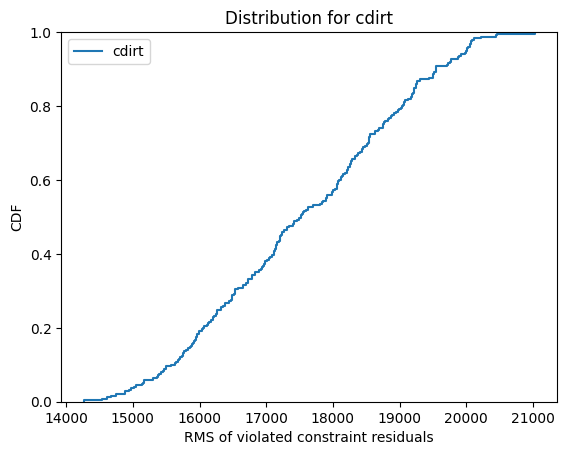

In [6]:
fig, ax = plt.subplots()

study_cdf_dfs = []

results = campaign.analyse(
    qoi_cols=["cdirt"]
)
# get_distribution() method not implemented for MCSampler
# not implemented in AnalysisResults (base) or QMCAnalysisResults (returned in MC case)
# Have to get distribution another way

# if type(results) == uq.analysis.qmc_analysis.QMCAnalysisResults:
# else:
#     dist = results.get_distribution(qoi="rms_vio_constr_res")

#     # Locations for density function to be evaluated
#     x = np.linspace(dist.lower[0], dist.upper[0], num=500)
#     cdf = dist.cdf(x)
#     sns.lineplot(x=x, y=cdf, markers=True, ax=ax, label=campaign_name)

# Try using using ecdfplot for all data, PCE or MC-obtained
results.samples.columns = results.samples.columns.droplevel(1)
samples = results.samples["cdirt"]
# samples = samples.rename(campaign_name)
study_cdf_dfs.append(samples)

cdfs = pd.concat(study_cdf_dfs, axis=1)
sns.ecdfplot(data=cdfs, ax=ax)
ax.set_title("Distribution for cdirt")
ax.set_xlabel("RMS of violated constraint residuals")
ax.set_ylabel("CDF")
# ax.set_xlim([0.0, None])

1, 2 and 3 params all very similar. Making fimp_14 uncertainty range well away from solution point (i.e. highly violating) shifts the curve to the right (3p_bad case). The Monte Carlo run (625 samples) broadly agrees with the PCE CDFs.

Most violated by frequency. Tricky to set a threshold: probably not the best.

## Sobol indices

### Violated constraint residuals

Sobols for violated constraint residuals.

Reading in campaign database.
Campaign read in. Number of samples = 250
Plotting Sobols for violated constraint residuals.


{'cdirt': {'step_ucsc_8': array([1.4175869]),
  'step_ref_69': array([3.50677235]),
  'step_ucblbe': array([0.84666968])}}

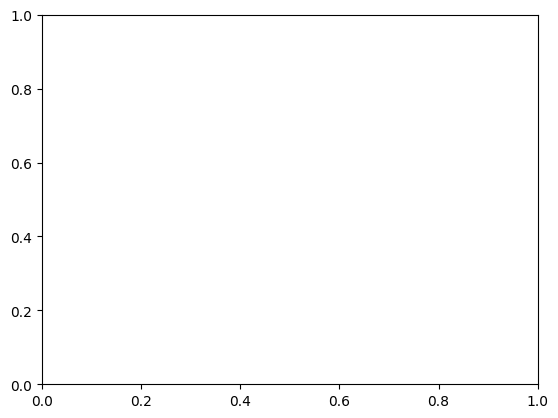

In [7]:
campaign, samples = analyse.read_campaign(campaign_name="example_local")

print("Plotting Sobols for violated constraint residuals.")
results = campaign.analyse(qoi_cols=["cdirt"])
fig, ax = plt.subplots()
# results.plot_sobols_treemap("cdirt", figsize=(10, 10), ax=ax)
# Can get a ZeroDivisionError in plot_sobols_treemap() if a Sobol index is 0
# fig.savefig("vio_constr_res_sobols_treemap.png")
results.sobols_first()

### Sobols for individual constraint

Interesting for discussion, but not for poster. Too much information (Sobol indices for each constraint).

Plotting individual constraint Sobols
Plotted cdirt Sobols.


/home/jg6173/easyVVUQ-process/uq-process/lib/python3.10/site-packages/easyvvuq/analysis/results.py:417: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


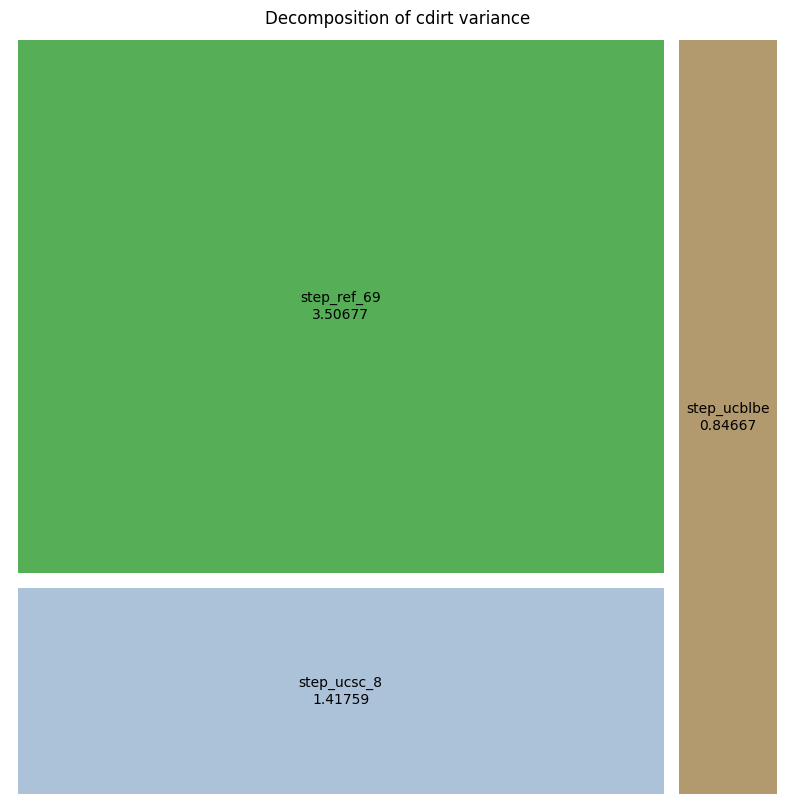

In [8]:
print("Plotting individual constraint Sobols")
vio_means_filt = vio_means_filt.reset_index(drop=True)
top_vio_means = vio_means_filt[0:3]["variable"].to_list()

results = campaign.analyse(qoi_cols=top_vio_means)
for constr_name in top_vio_means:
    fig, ax = plt.subplots()
    try:
        results.plot_sobols_treemap(constr_name, ax=ax)
        # fig.savefig(f"{constr_name}_sobols_treemap.png")
        print(f"Plotted {constr_name} Sobols.")
    except:
        print(f"Couldn't plot {constr_name} Sobols.")

## Barplot of Sobol indices

Plotting barplot of Sobols for direct cost.


Text(0, 0.5, 'Uncertain input')

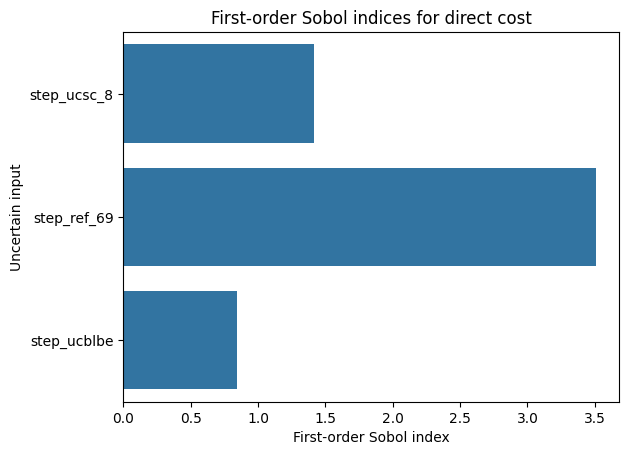

In [9]:
print("Plotting barplot of Sobols for direct cost.")
# results.sobols_first()
# results.sobols_second()
# results.sobols_total()

results = campaign.analyse(qoi_cols=["cdirt"])
sobols_first = results.sobols_first()["cdirt"]
sobols_first_df = pd.DataFrame(sobols_first)
sobols_first_df_melted = sobols_first_df.melt()
sobols_first_df_melted

fig, ax = plt.subplots()
sns.barplot(data=sobols_first_df_melted, x="value", y="variable", ax=ax)
ax.set_title("First-order Sobol indices for direct cost")
ax.set_xlabel("First-order Sobol index")
ax.set_ylabel("Uncertain input")
# fig.savefig("fo_sobols_bar.png")

Plotting first and higher-order Sobols for direct cost.


Text(0, 0.5, 'Uncertain input')

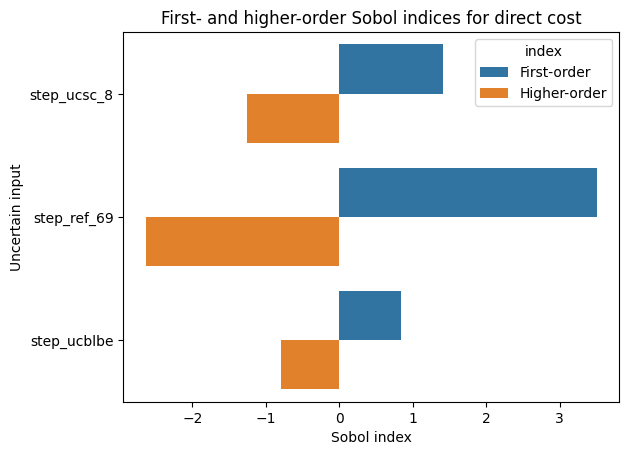

In [10]:
print("Plotting first and higher-order Sobols for direct cost.")
sobols_total = results.sobols_total()["cdirt"]

# Calculate higher-order Sobol indices
sobols_higher = {}
for key in sobols_first:
    sobols_higher[key] = sobols_total[key] - sobols_first[key]

# Combine first and higher-order into df
sobols_first_and_higher = {}
for key in sobols_first:
    sobols_first_and_higher[key] = [sobols_first[key][0], sobols_higher[key][0]]

sobols_first_and_higher_df = pd.DataFrame(
    sobols_first_and_higher, index=["First-order", "Higher-order"]
)
sobols_first_and_higher_df = sobols_first_and_higher_df.reset_index()
sobols_first_and_higher_df
sobols_first_and_higher_df_melted = sobols_first_and_higher_df.melt(id_vars="index")
sobols_first_and_higher_df_melted

# Plot
fig, ax = plt.subplots()
ax = sns.barplot(
    data=sobols_first_and_higher_df_melted,
    x="value",
    y="variable",
    hue="index",
    orient="h",
)
ax.set_title("First- and higher-order Sobol indices for direct cost")
ax.set_xlabel("Sobol index")
ax.set_ylabel("Uncertain input")
# fig.savefig("fo_ho_sobols_bar.png")